In [1]:
import pandas as pd
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
bpi_ft = pd.read_csv("../data/34_bpic_features.csv").sort_values('log')
gen =pd.read_csv("../output/generated/instance_selection_feat.csv")
paper_cols = ["log","ratio_unique_traces_per_trace", "ratio_most_common_variant", 'ratio_top_10_variants', 'epa_normalized_variant_entropy', 'epa_normalized_sequence_entropy', 'epa_normalized_sequence_entropy_linear_forgetting', 'epa_normalized_sequence_entropy_exponential_forgetting'] 
bpi_ft= bpi_ft[paper_cols]
print(gen.shape, bpi_ft.shape)
#print(gen.columns == df.columns)
bpi_ft['source']='BPICs'
gen['source']='Generated'
both_df = pd.concat([bpi_ft, gen])
print(both_df.shape)
feature_logs = both_df['log'].unique()

(467, 8) (34, 8)
(501, 9)


In [3]:
bpi_pd = pd.read_csv("../output/benchmark/bpics_PDbenchmark.csv").sort_values('log')
gen_pd = pd.read_csv("../output/benchmark/instance_selection_3_2_bench.csv")
#gen_pd = gen_pd.sample(30)

print(gen_pd.shape, bpi_pd.shape)
bpi_pd['source']='BPICs'
gen_pd['source']='Generated'
both_pd = pd.concat([bpi_pd, gen_pd])
both_pd['log']=both_pd.apply(lambda x: x['log'].replace(".xes",""), axis=1)
both_pd['log']=both_pd.apply(lambda x: x['log'].replace("_processed",""), axis=1)
print(both_pd.shape)
print(both_pd.columns)
print(both_df.columns)

benchmarked_logs = both_pd['log'].unique()
#both_pd.head(20)

(339, 7) (13, 7)
(352, 8)
Index(['log', 'fitness_inductive', 'precision_inductive', 'fitness_heuristics',
       'precision_heuristics', 'fitness_ilp', 'precision_ilp', 'source'],
      dtype='object')
Index(['log', 'ratio_unique_traces_per_trace', 'ratio_most_common_variant',
       'ratio_top_10_variants', 'epa_normalized_variant_entropy',
       'epa_normalized_sequence_entropy',
       'epa_normalized_sequence_entropy_linear_forgetting',
       'epa_normalized_sequence_entropy_exponential_forgetting', 'source'],
      dtype='object')


In [4]:
import numpy as np
from sklearn.impute import SimpleImputer
ft_perf = pd.concat([both_df.set_index('log'), both_pd.set_index('log')], axis=1, join="inner").reset_index()
ft_perf = ft_perf.T.drop_duplicates().T
print(len(ft_perf[ft_perf['source']=="BPICs"]['log']))
print(ft_perf.shape)

benchmarked_ft = ft_perf[both_df.columns]
benchmarked_pd = ft_perf[both_pd.columns]
print(len(benchmarked_ft[benchmarked_ft['source']=="BPICs"]['log']))
print(benchmarked_ft.shape)
print(len(benchmarked_pd[benchmarked_pd['source']=="BPICs"]['log']))
print(benchmarked_pd.shape)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(benchmarked_ft.drop(['log','source'], axis=1))
imp_df = imp_mean.transform(benchmarked_ft.drop(['log','source'], axis=1))
imp_df = pd.DataFrame(imp_df, columns = benchmarked_ft.columns[2:])
print("Before:", len(benchmarked_ft.loc[:, benchmarked_ft.isna().any()].columns), "columns in", len(benchmarked_ft.loc[:, benchmarked_ft.isna().any()]), 'rows')
print("After:", len(imp_df.loc[:, imp_df.isna().any()].columns))

13
(352, 15)
13
(352, 9)
13
(352, 8)
Before: 0 columns in 352 rows
After: 0


In [5]:
#benchmarked_ft.head(20)

In [6]:
#benchmarked_ft= benchmarked_ft.reset_index(drop=True)
#both_pd =both_pd.reset_index(drop=True)
#ft_perf = pd.concat([benchmarked_ft, both_pd], axis=1, join="inner").reset_index(drop=True)
#print(len(ft_perf[ft_perf['source']=='BPICs']['log']))
#ft_perf.columns

Feature similarity: (10, 342)


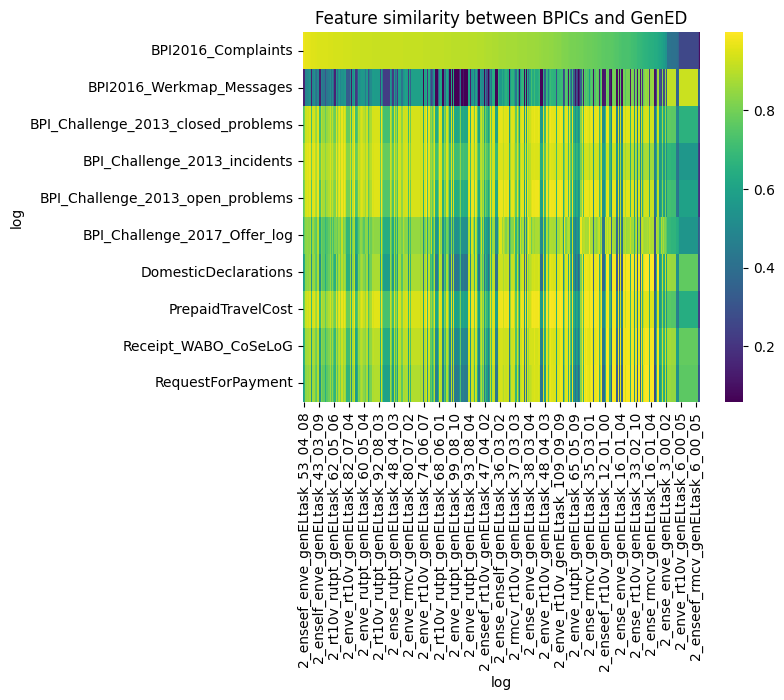

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

ft_similarity = cosine_similarity(imp_df.select_dtypes(exclude=['object']))
ft_similarity = pd.DataFrame(ft_similarity, columns=benchmarked_ft['log'], index=benchmarked_ft['log'])#.sort_values(by='BPI_Challenge_2013_closed_problems')
ft_similarity = ft_similarity.loc[ft_similarity.columns[10:],ft_similarity.columns[:10]].copy()
ft_similarity = ft_similarity.sort_values(by=ft_similarity.columns[0], ascending=False).transpose()
#with_pcs.loc[:,~with_pcs.columns.duplicated()].copy()
print("Feature similarity:", ft_similarity.shape)

import matplotlib.pyplot as plt
import numpy as np

#plt.imshow(ft_similarity, cmap='viridis', interpolation='nearest')
sns.heatmap(ft_similarity.astype(np.float16), cmap="viridis")
ax = plt.gca()
ax.set_title("Feature similarity between BPICs and GenED")
plt.show()

Metrics similarity: (10, 342)


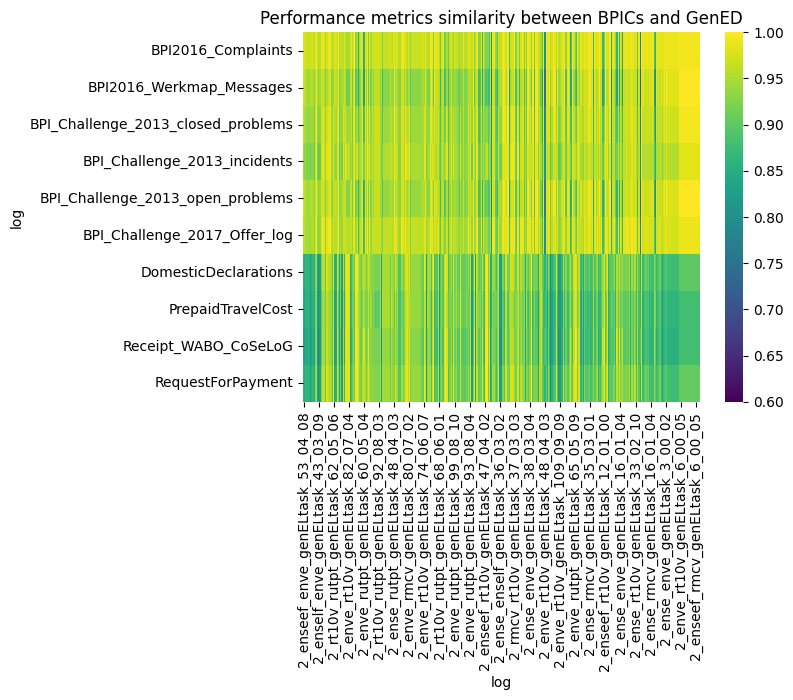

In [8]:
#print(benchmarked_pd.convert_dtypes().dtypes)
#print(benchmarked_pd.convert_dtypes().select_dtypes(exclude=['string']))

#print(both_pd)
#ft_similarity = cosine_similarity(imp_df.select_dtypes(exclude=['object']))
pdm_similarity = cosine_similarity(benchmarked_pd.convert_dtypes().select_dtypes(exclude=['string']))
pdm_similarity = pd.DataFrame(pdm_similarity, columns=benchmarked_pd['log'], index=benchmarked_pd['log'])#.sort_values(by='BPI_Challenge_2013_closed_problems')
pdm_similarity = pdm_similarity.loc[pdm_similarity.columns[10:],pdm_similarity.columns[:10]].copy()
pdm_similarity = pdm_similarity.transpose()[ft_similarity.columns]#.sort_values(by=ft_similarity.columns[0], ascending=False)

print("Metrics similarity:", pdm_similarity.shape)
#plt.imshow(pdm_similarity, cmap='viridis', interpolation='nearest')
sns.heatmap(pdm_similarity.astype(np.float16), cmap="viridis", vmin=0.6)
ax = plt.gca()
ax.set_title("Performance metrics similarity between BPICs and GenED")

plt.show()

## Statistical test: Is there a statistical significant relation between feature similarity and performance metrics?

In [9]:
from scipy.stats import pearsonr
from scipy.stats import kendalltau

data1 = ft_similarity.to_numpy().flatten()
data2 = pdm_similarity.to_numpy().flatten()

stat, p = kendalltau(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=-0.018, p=0.122
Probably independent


13
Index(['log', 'ratio_unique_traces_per_trace', 'ratio_most_common_variant',
       'ratio_top_10_variants', 'epa_normalized_variant_entropy',
       'epa_normalized_sequence_entropy',
       'epa_normalized_sequence_entropy_linear_forgetting',
       'epa_normalized_sequence_entropy_exponential_forgetting', 'source'],
      dtype='object')
13
(13, 9)
(13, 8)
['rutpt', 'rmcv', 'rt10v', 'enve', 'ense', 'enself', 'enseef']


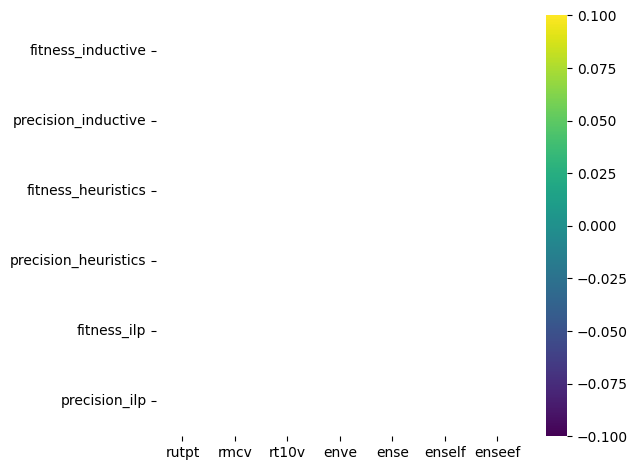

In [10]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.dirname("../tag/utils/io_helpers.py"))
from io_helpers import get_keys_abbreviation


#benchmarked_pdm = both_pd[both_pd['log'].isin(intersect_logs)].copy()
#print(len(benchmarked_pdm[benchmarked_pdm['source']=="BPICs"]['log']))

benchmarked_pdm = ft_perf[both_pd.columns]
print(len(benchmarked_pdm[benchmarked_pdm['source']=="BPICs"]['log']))
print(benchmarked_ft.columns)

print(len(benchmarked_ft[benchmarked_ft['source']=="BPICs"]['log']))
benchmarked_ft_plot = benchmarked_ft.copy()[benchmarked_ft['source']=="BPICs"]#=="Generated"]
benchmarked_pdm_plot = benchmarked_pdm.copy()[benchmarked_pdm['source']=="BPICs"]#=="Generated"]

#benchmarked_ft = benchmarked_ft.head(10)
#benchmarked_pdm = benchmarked_pdm.head(10)

print(benchmarked_ft_plot.shape)
print(benchmarked_pdm_plot.shape)
tmp = list(benchmarked_ft_plot.columns[1:-1])
df_tmp = pd.DataFrame(index=benchmarked_pdm_plot.columns[1:-1], columns=tmp)
#print("Benchmark_pdm:", benchmarked_pdm.columns[1:-1])
#print ("Benchmark_ft:", tmp)


for feature in benchmarked_ft_plot.columns:
    if feature != 'log' and feature != 'source':
        for metric in benchmarked_pdm_plot.columns:
            if metric != 'log' and metric != 'source':
                #print(feature, benchmarked_pdm.columns[1])
                stat, p = kendalltau(benchmarked_ft_plot[feature], benchmarked_pdm_plot[metric])
                #print(feature, metric, p, p <= 0.05)
                df_tmp.loc[metric, feature] = stat*(1.0 if (p <= 0.05) else 0.0)

feature_keys = get_keys_abbreviation(df_tmp.columns).split("_")
print(feature_keys)
df_tmp.columns=feature_keys
# df_tmp[pd.isnan()]

sns.heatmap(df_tmp.fillna(0), annot=True, cmap="viridis", annot_kws={"size": 9})
ax = plt.gca()
sns.heatmap(df_tmp.fillna(0), mask=df_tmp.fillna(0)!=0, cmap="Greys", annot=False, cbar=False, ax=ax)
#ax.set_title("P-values of features leading to process discovery metrics", fontsize=15)
plt.tight_layout()
#plt.savefig("../output/plots/pearson_feature_PDmetric", dpi=300)

13
Index(['log', 'ratio_unique_traces_per_trace', 'ratio_most_common_variant',
       'ratio_top_10_variants', 'epa_normalized_variant_entropy',
       'epa_normalized_sequence_entropy',
       'epa_normalized_sequence_entropy_linear_forgetting',
       'epa_normalized_sequence_entropy_exponential_forgetting', 'source'],
      dtype='object')
13
(13, 9)
(13, 8)


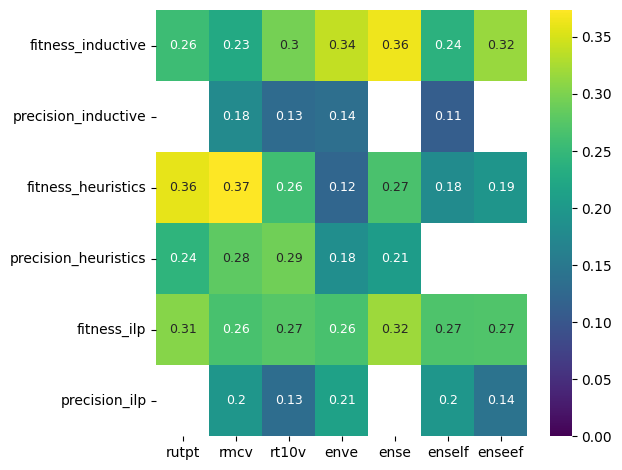

In [11]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

benchmarked_pdm = ft_perf[both_pd.columns]
print(len(benchmarked_pdm[benchmarked_pdm['source']=="BPICs"]['log']))
print(benchmarked_ft.columns)

print(len(benchmarked_ft[benchmarked_ft['source']=="BPICs"]['log']))
benchmarked_ft_plot = benchmarked_ft[benchmarked_ft['source']=="BPICs"]#=="Generated"]
benchmarked_pdm_plot = benchmarked_pdm[benchmarked_pdm['source']=="BPICs"]#=="Generated"]

print(benchmarked_ft_plot.shape)
print(benchmarked_pdm_plot.shape)
tmp = list(benchmarked_ft_plot.columns[1:-1])
df_tmp = pd.DataFrame(index=benchmarked_pdm_plot.columns[1:-1], columns=tmp)
#print("Benchmark_pdm:", benchmarked_pdm.columns[1:-1])
#print ("Benchmark_ft:", tmp)


for feature in benchmarked_ft_plot.columns:
    if feature != 'log' and feature != 'source':
        for metric in benchmarked_pdm.columns:
            if metric != 'log' and metric != 'source':
                #print(feature, benchmarked_pdm.columns[1])
                X = benchmarked_ft_plot[feature].to_numpy()
                ft_sim = (1-np.abs(np.subtract.outer(X,X)/max(X))).flatten()
                Y = benchmarked_pdm_plot[metric].to_numpy()
                pdm_sim = (1-np.abs(np.subtract.outer(Y,Y))/Y).flatten()
                #print(ft_sim.shape, pdm_sim.shape)
                stat, p = kendalltau(ft_sim, pdm_sim)
                #print(feature, metric, p, p <= 0.05)
                df_tmp.loc[metric, feature] = stat*(1.0 if (p <= 0.05) else 0)

# df_tmp[pd.isnan()]

feature_keys = get_keys_abbreviation(df_tmp.columns).split("_")
#print(feature_keys)
df_tmp.columns=feature_keys
sns.heatmap(df_tmp.fillna(0), annot=True, cmap="viridis", annot_kws={"size": 9})
ax = plt.gca()
sns.heatmap(df_tmp.fillna(0), mask=df_tmp.fillna(0)!=0, cmap="Greys", annot=True, annot_kws={"color":"white", "size": 9},  cbar=False, ax=ax)


#ax.set_title("P-values of feature similarity leading to process discovery metrics similarity", fontsize=15)
plt.tight_layout()
#plt.savefig("../output/plots/pearson_similarities_features_PDmetric", dpi=300)

In [12]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
X = [1, 2, 3, 4]
Y = np.random.randint(5, size=4)
# distance between rows of X

# get distance to origin
distX = np.abs(np.subtract.outer(X,X))#.flatten()
simX = 1-np.abs(np.subtract.outer(X,X)/max(X))#.flatten()

print(distX, "\n\n", simX)
distY = np.abs(np.subtract.outer(Y,Y))#.flatten()
simY = 1-np.abs(np.subtract.outer(Y,Y)/max(Y))#.flatten()


stat, p = pearsonr(X,Y)
print(stat, p)
stat, p = pearsonr(simX.flatten(),simY.flatten())
print(Y)
print(stat, p)

[[0 1 2 3]
 [1 0 1 2]
 [2 1 0 1]
 [3 2 1 0]] 

 [[1.   0.75 0.5  0.25]
 [0.75 1.   0.75 0.5 ]
 [0.5  0.75 1.   0.75]
 [0.25 0.5  0.75 1.  ]]
0.9393364366277241 0.06066356337227585
[0 0 3 4]
0.8588975014708023 2.039365082862659e-05


In [13]:
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr
data1 = ft_similarity.to_numpy().flatten()
data2 = pdm_similarity.to_numpy().flatten()

stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=-0.026, p=0.127
Probably independent


In [14]:
# Example of the Kendall's Rank Correlation Test
from scipy.stats import kendalltau
data1 = ft_similarity.to_numpy().flatten()
data2 = pdm_similarity.to_numpy().flatten()

stat, p = kendalltau(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=-0.018, p=0.122
Probably independent


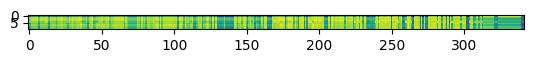

In [15]:
plt.imshow((ft_similarity+pdm_similarity)*1/2, cmap='viridis', interpolation='nearest')
plt.show()

<AxesSubplot: xlabel='feature_similarity', ylabel='evaluation_similarity'>

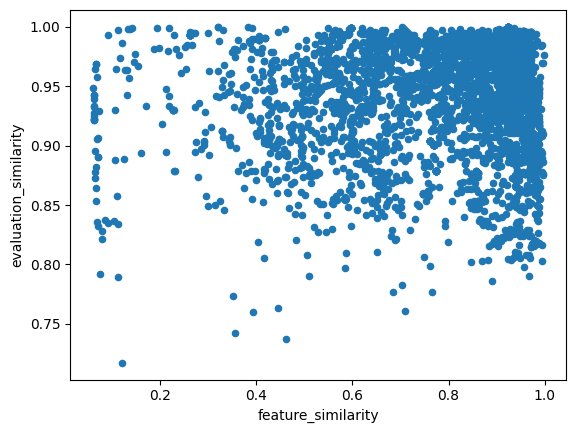

In [16]:
ft_similarity.to_numpy().flatten()
df = pd.DataFrame({'feature_similarity':ft_similarity.to_numpy().flatten(), 'evaluation_similarity':pdm_similarity.to_numpy().flatten()})
df.plot('feature_similarity', 'evaluation_similarity', kind='scatter')

## Linear Regression

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression


/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_17711/3877389065.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['feature_similarity'])


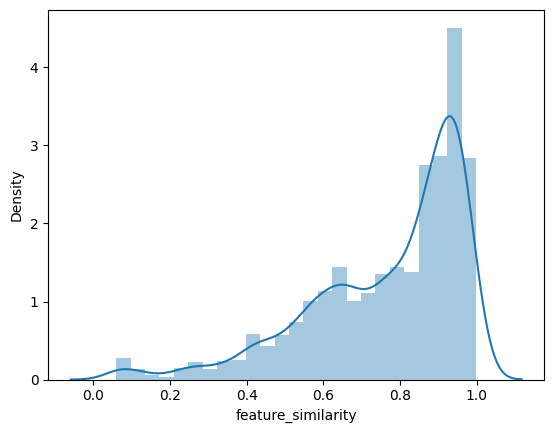

In [18]:
sns.distplot(df['feature_similarity'])
plt.show()

/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_17711/1924355711.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['evaluation_similarity'])


<AxesSubplot: xlabel='evaluation_similarity', ylabel='Density'>

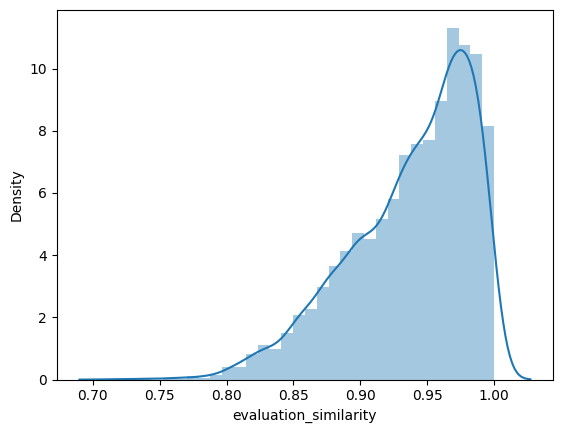

In [19]:
sns.distplot(df['evaluation_similarity'])

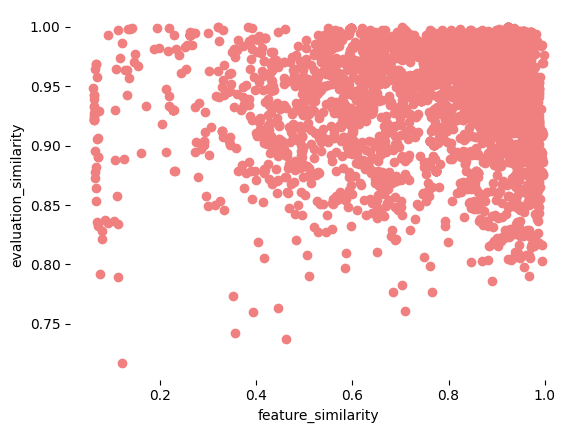

In [20]:
plt.scatter(df['feature_similarity'], df['evaluation_similarity'], color = 'lightcoral')
plt.xlabel('feature_similarity')
plt.ylabel('evaluation_similarity')
plt.box(False)
#plt.ylim((0,1))
plt.show()

In [21]:
# Splitting variables
X = df.iloc[:, :1]  # independent
y = df.iloc[:, 1:]  # dependent
# Splitting dataset into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [22]:
# Regressor model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [23]:
# Prediction result
y_pred_test = regressor.predict(X_test)     # predicted value of y_test
y_pred_train = regressor.predict(X_train)   # predicted value of y_train

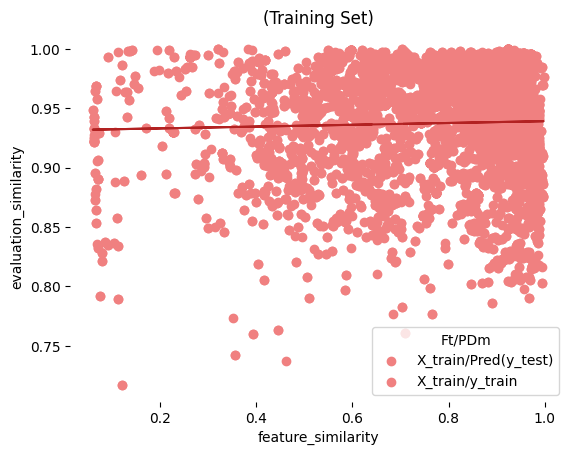

In [24]:
plt.scatter(df['feature_similarity'], df['evaluation_similarity'], color = 'lightcoral')

# Prediction on training set
plt.scatter(X_train, y_train, color = 'lightcoral')
plt.plot(X_train, y_pred_train, color = 'firebrick')
plt.title('(Training Set)')
plt.xlabel('feature_similarity')
plt.ylabel('evaluation_similarity')
plt.legend(['X_train/Pred(y_test)', 'X_train/y_train'], title = 'Ft/PDm', loc='best', facecolor='white')
plt.box(False)
#plt.ylim((0,1))
plt.show()

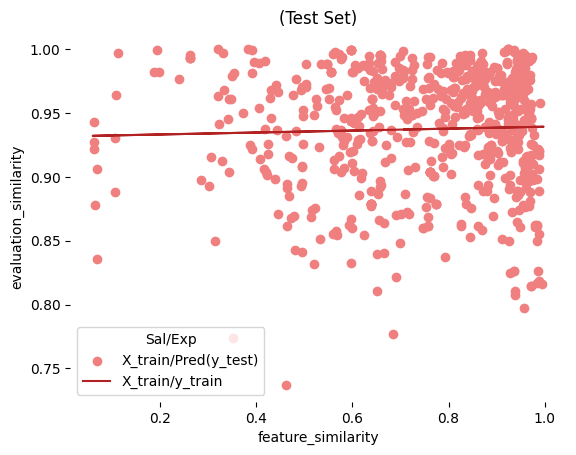

In [25]:
# Prediction on test set
plt.scatter(X_test, y_test, color = 'lightcoral')
plt.plot(X_train, y_pred_train, color = 'firebrick')
plt.title('(Test Set)')
plt.xlabel('feature_similarity')
plt.ylabel('evaluation_similarity')
plt.legend(['X_train/Pred(y_test)', 'X_train/y_train'], title = 'Sal/Exp', loc='best', facecolor='white')
plt.box(False)
plt.show()

In [26]:
# Regressor coefficients and intercept
print(f'Coefficient: {regressor.coef_}')
print(f'Intercept: {regressor.intercept_}')

Coefficient: [[0.00758288]]
Intercept: [0.93148292]


## Multiple linear regression

In [27]:
benchmarked_ft= benchmarked_ft.reset_index(drop=True)
both_pd =both_pd.reset_index(drop=True)
ft_perf = pd.concat([benchmarked_ft, both_pd], axis=1, join="inner")

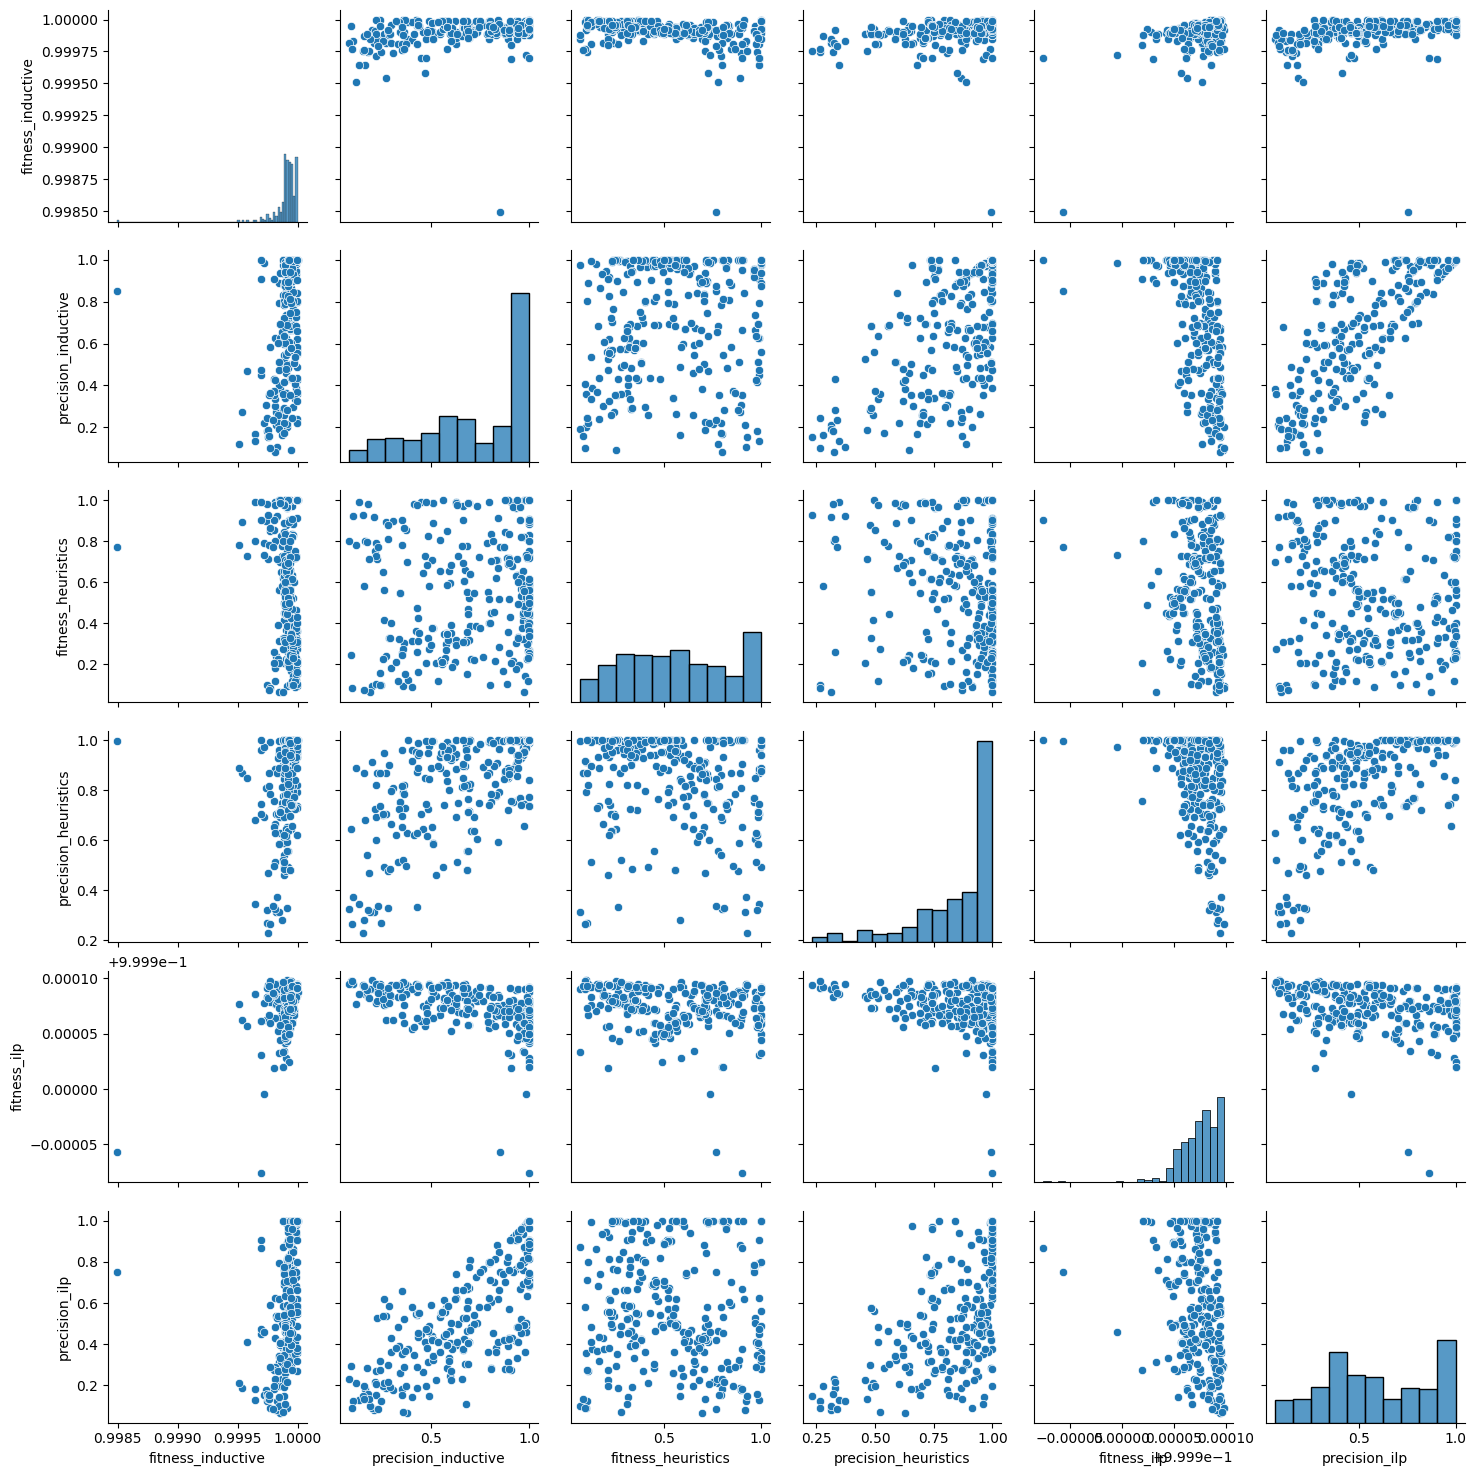

In [28]:
sns.pairplot(ft_perf.select_dtypes(exclude=['object']))
#plt.show()

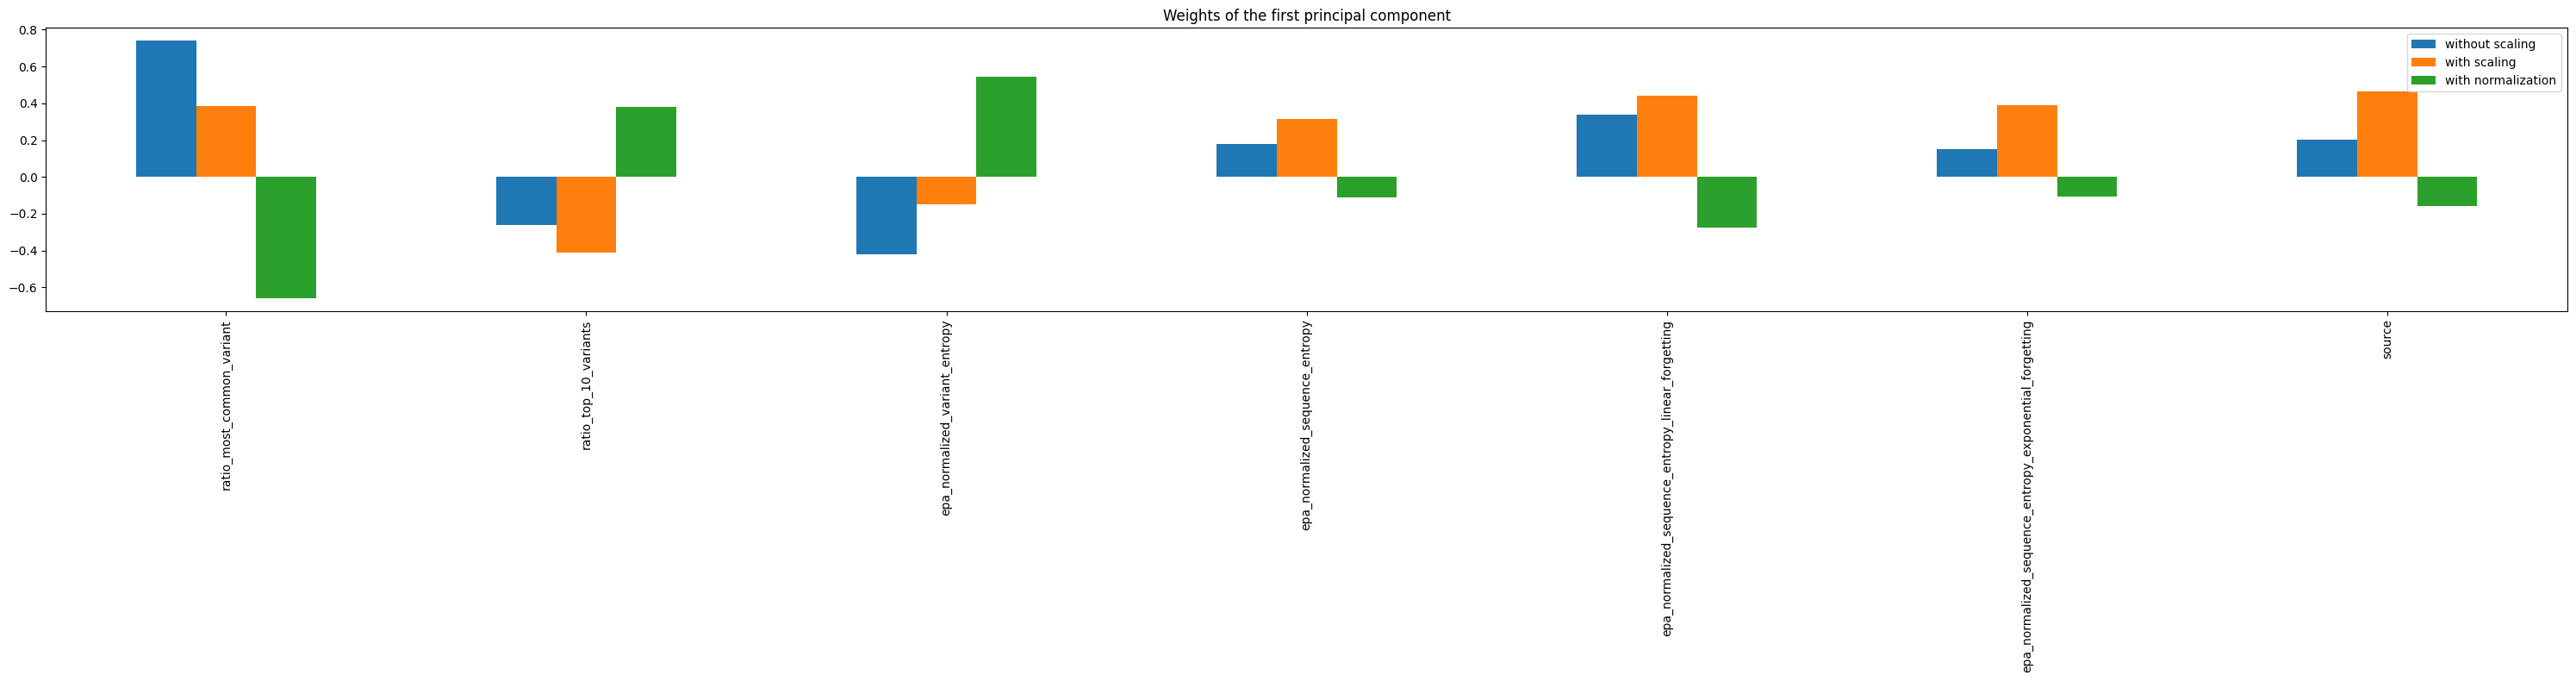

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

X = imp_df
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X)
normed_X = Normalizer(norm="l2").fit_transform(X)


import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X)
scaled_pca = PCA(n_components=2).fit(scaled_X_train)
norm_pca = PCA(n_components=2).fit(normed_X)


X_train_transformed = pca.transform(X)
X_train_std_transformed = scaled_pca.transform(scaled_X_train)
X_train_norm_transformed = norm_pca.transform(normed_X)


first_pca_component = pd.DataFrame(
    pca.components_[0], index=X.columns, columns=["without scaling"]
)
first_pca_component["with scaling"] = scaled_pca.components_[0]
first_pca_component["with normalization"] = norm_pca.components_[0]
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(30, 8)
)

_ = plt.tight_layout()

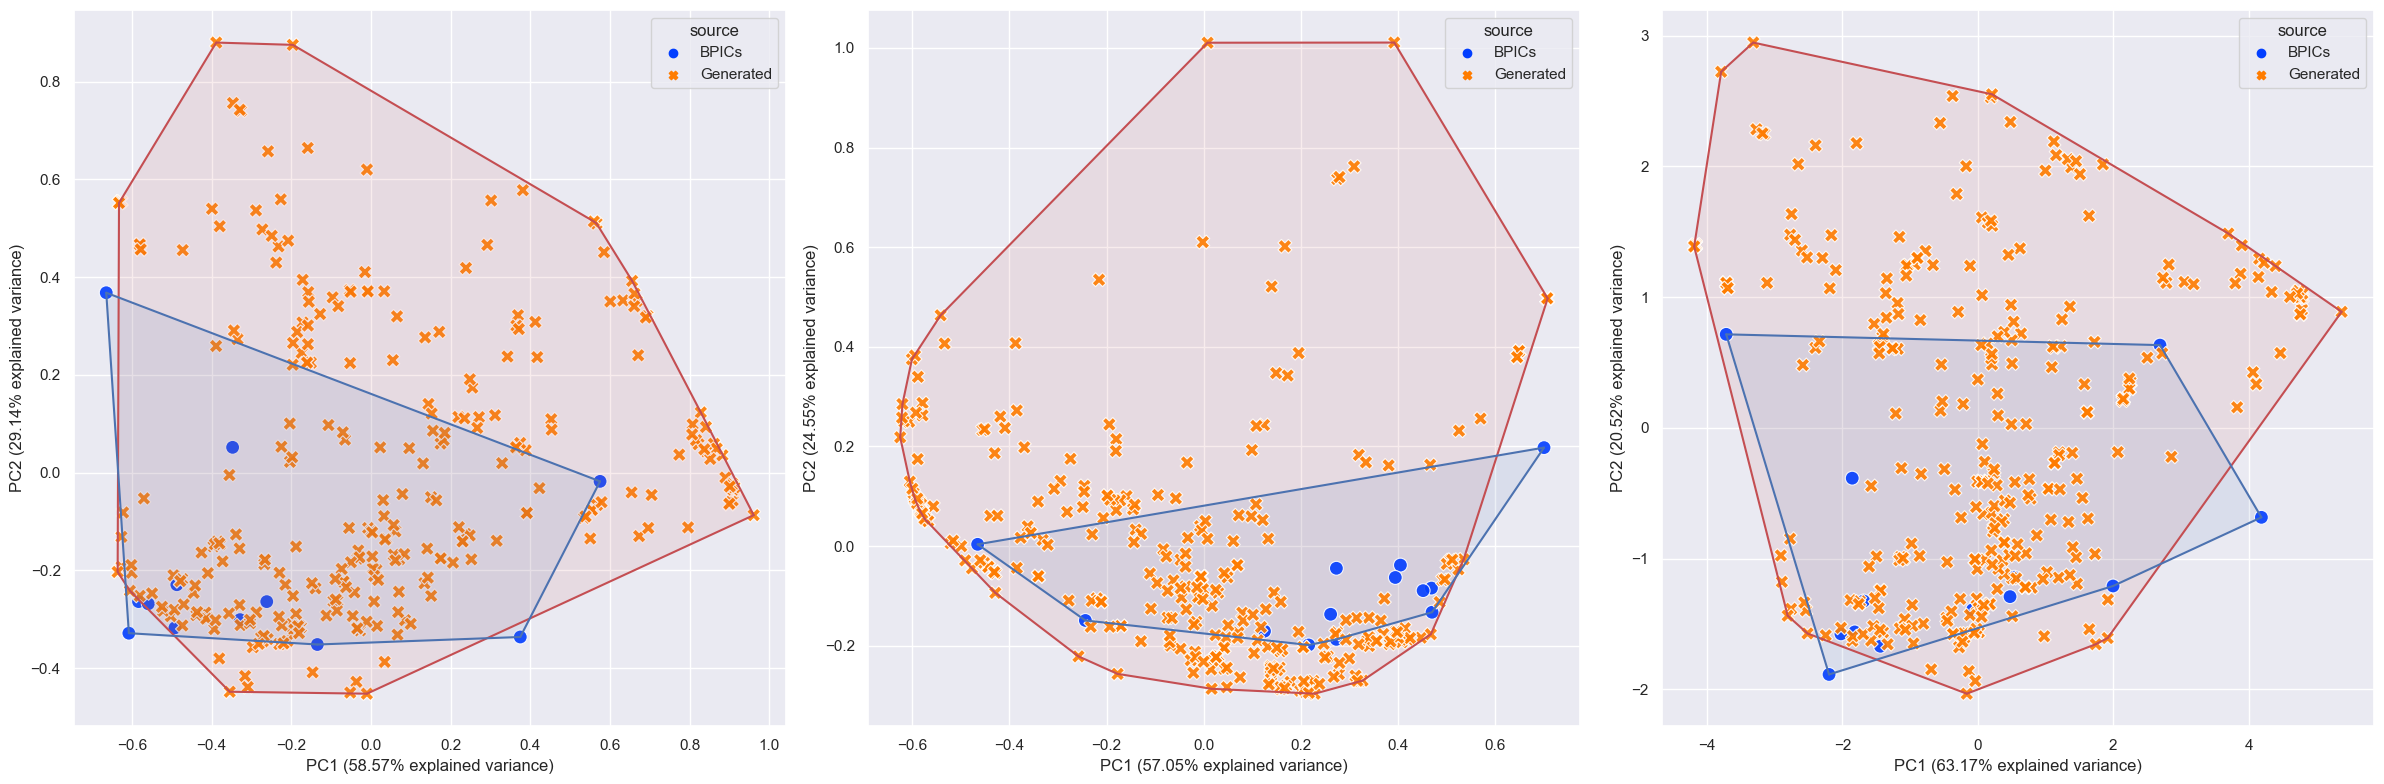

In [30]:
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull


def plot_convex_hull(numbers, ax, style, color):
    hull = ConvexHull(numbers)
    for simplex in hull.simplices:
        ax.plot(numbers[simplex, 0], numbers[simplex, 1], style)
    ax.fill(numbers[hull.vertices,0], numbers[hull.vertices,1], color, alpha=0.1)

pca = PCA(n_components=2)

# Normalizer: By default, L2 normalization is applied to each observation so the that the values in a row have a unit norm. 
    # Unit norm with L2 means that if each element were squared and summed, the total would equal 1. 
    #Normalizer does transform all the features to values between -1 and 1. 
#norm_data = Normalizer(norm="l2").fit_transform(df.drop(["log"], axis=1))
norm_data = Normalizer(norm="l2").fit_transform(X)

#StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. 
    #Unit variance means dividing all the values by the standard deviation.
scaler = StandardScaler()
sca_data = scaler.fit_transform(X)
#norm_data = Normalizer(norm="l2").fit_transform(norm_data)

sns.set_theme()
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24, 8))

X_new = pca.fit_transform(X)
df_pca = pd.DataFrame(X_new, columns=["PC1", "PC2"])
df_pca['source']=benchmarked_ft['source'].to_numpy()
numbers_gen = df_pca[df_pca['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca[df_pca['source'] == 'BPICs'][['PC1', 'PC2']].to_numpy()

sns.scatterplot(ax=ax1, data=df_pca, x="PC1", y="PC2", palette="bright", hue='source',
                alpha=0.9, s=100, style="source")
plot_convex_hull(numbers_gen, ax1, 'r-', 'r')
plot_convex_hull(numbers_real, ax1, 'b-', 'b')

ax1.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)")
ax1.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)")


X_new_norm = pca.fit_transform(norm_data)
df_pca_norm = pd.DataFrame(X_new_norm, columns=["PC1", "PC2"])
df_pca_norm['source']=benchmarked_ft['source'].to_numpy()
numbers_gen = df_pca_norm[df_pca_norm['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca_norm[df_pca_norm['source'] == 'BPICs'][['PC1', 'PC2']].to_numpy()
plot_convex_hull(numbers_gen, ax2, 'r-', 'r')
plot_convex_hull(numbers_real, ax2, 'b-', 'b')

sns.scatterplot(ax=ax2, data=df_pca_norm, x="PC1", y="PC2", palette="bright", hue='source', alpha=0.9, s=100, style="source")
ax2.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)")
ax2.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)")

X_new_sca = pca.fit_transform(sca_data)
df_pca_sca = pd.DataFrame(X_new_sca, columns=["PC1", "PC2"])
df_pca_sca['source']=benchmarked_ft['source'].to_numpy()
numbers_gen = df_pca_sca[df_pca_sca['source'] == 'Generated'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca_sca[df_pca_sca['source'] == 'BPICs'][['PC1', 'PC2']].to_numpy()
plot_convex_hull(numbers_gen, ax3, 'r-', 'r')
plot_convex_hull(numbers_real, ax3, 'b-', 'b')
sns.scatterplot(ax=ax3, data=df_pca_sca, x="PC1", y="PC2", palette="bright", hue='source', alpha=0.9, s=100, style="source")
ax3.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)")
ax3.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)")
plt.tight_layout()
# plt.show()
# plt.close()


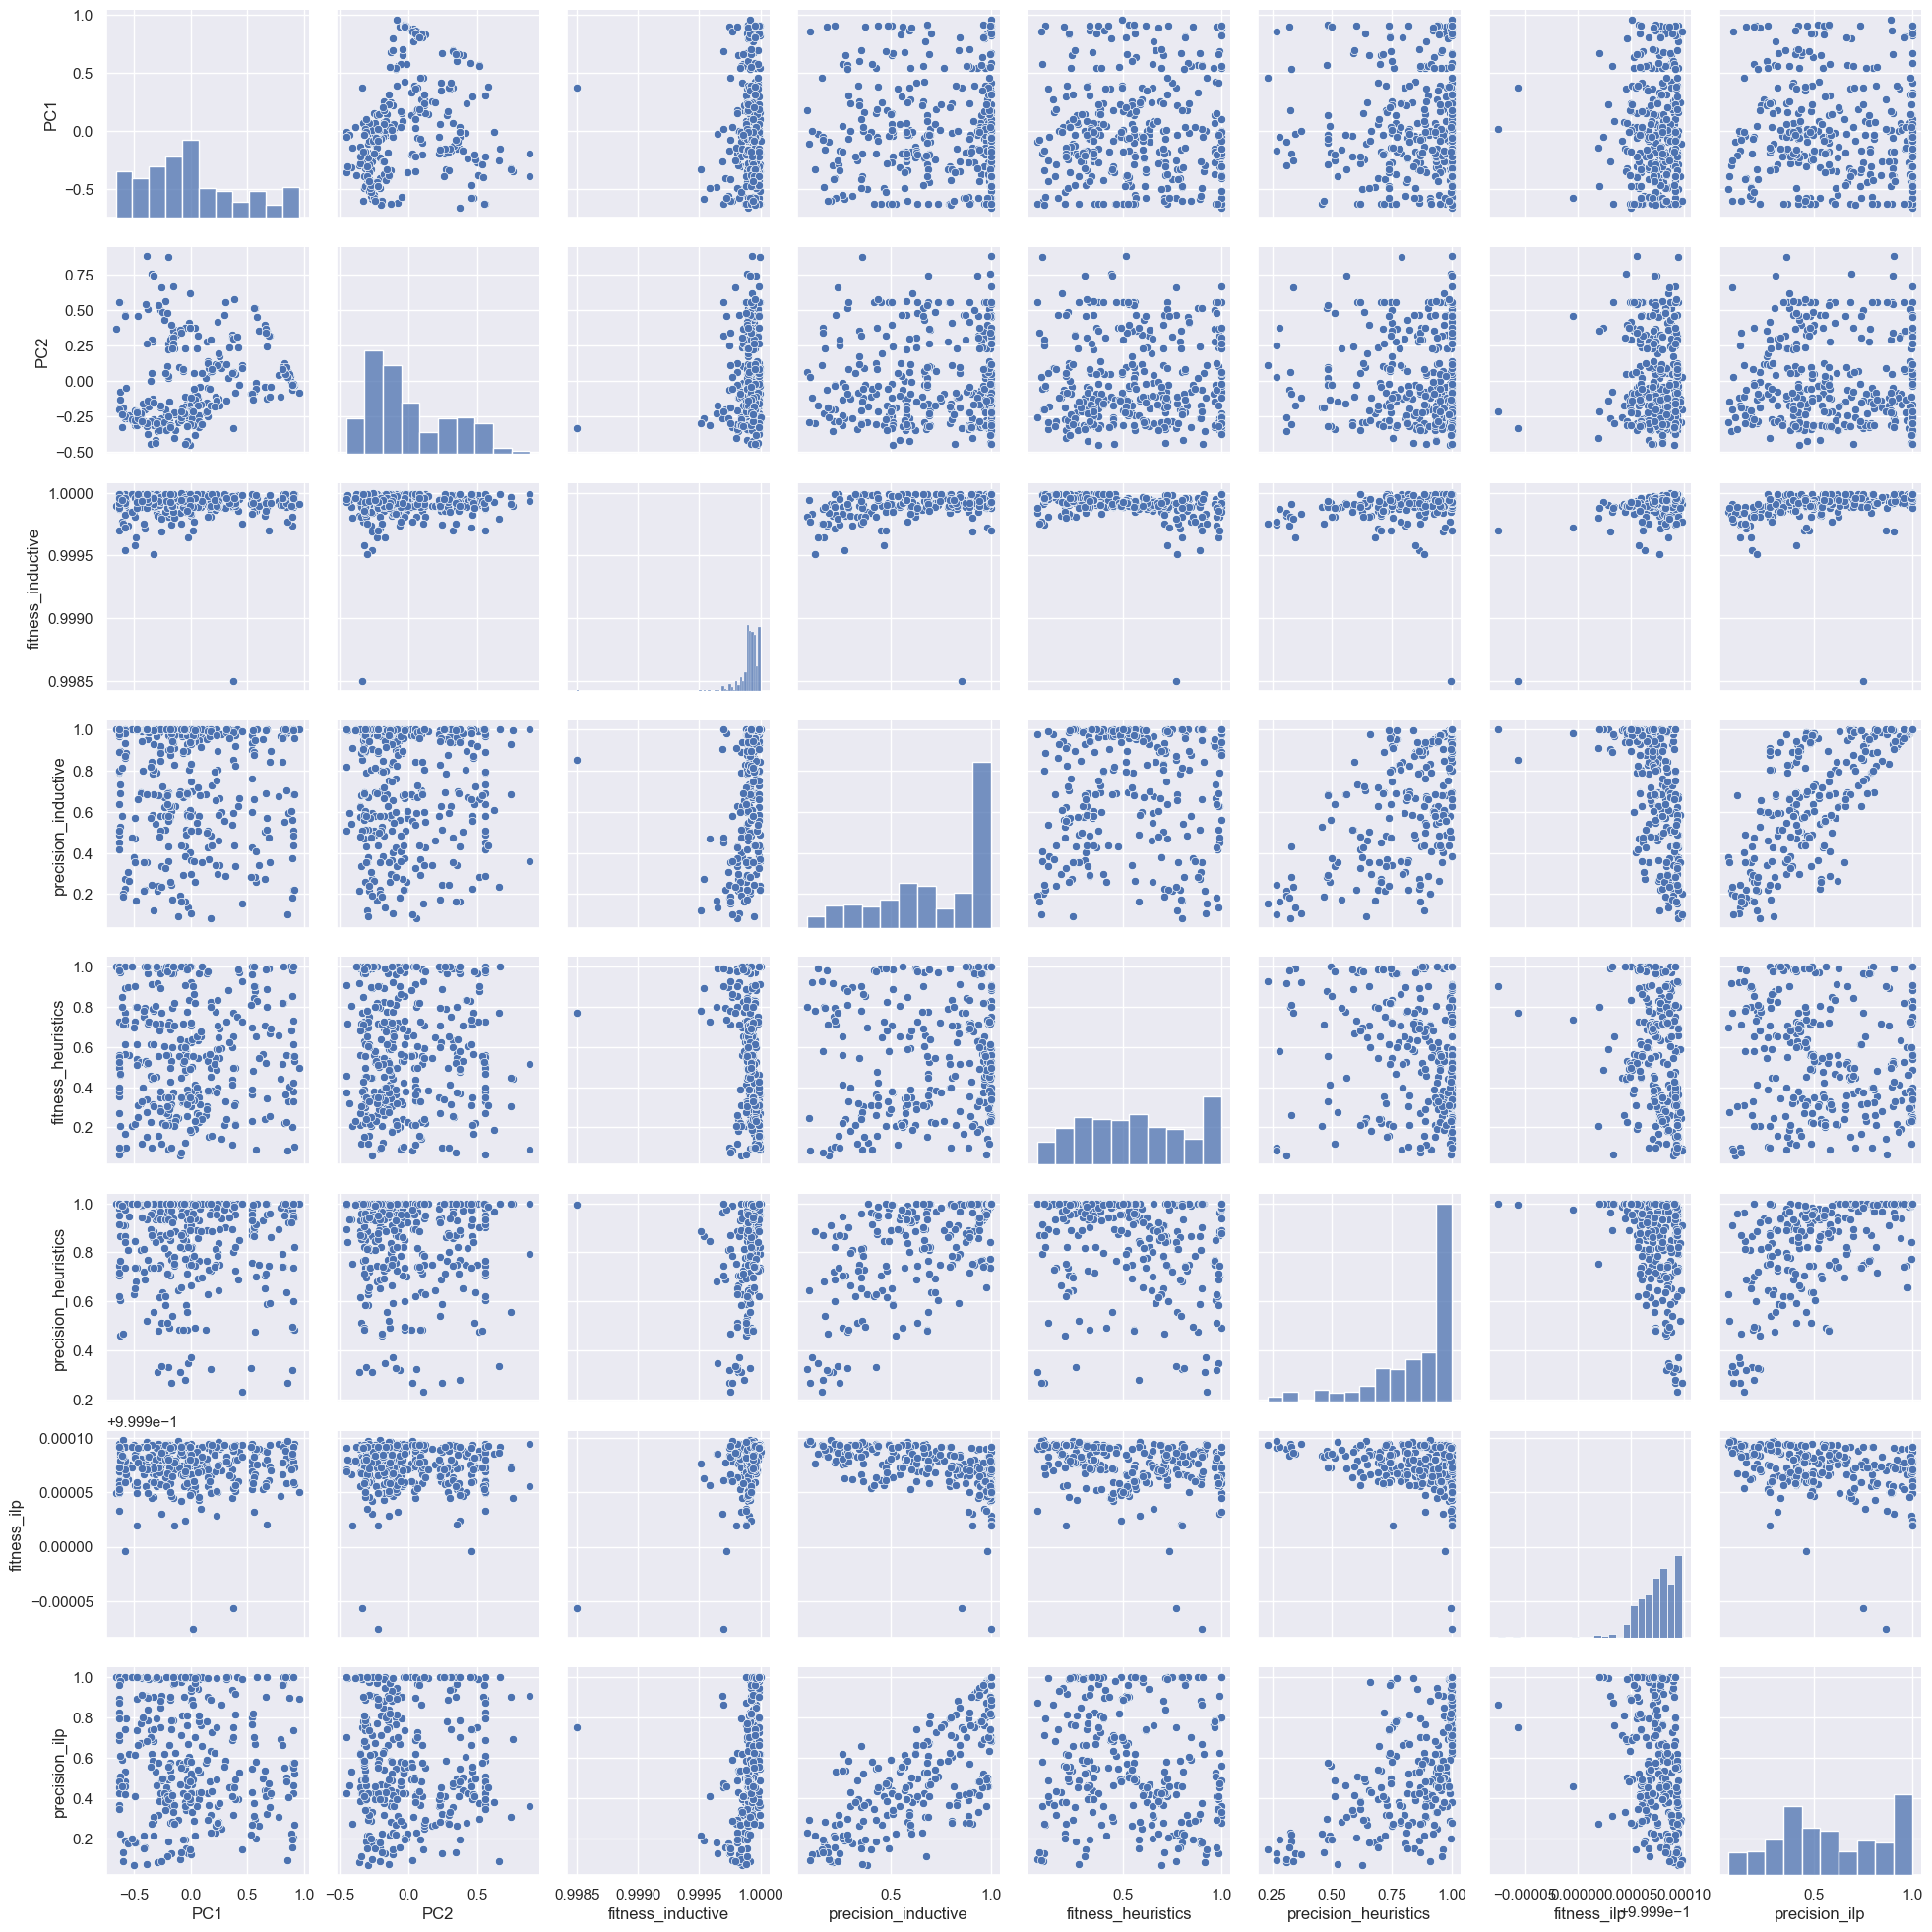

In [31]:
with_pcs = pd.concat([df_pca, ft_perf], axis=1, join="inner")
pc_cols = ['log', 'PC1',
       'PC2', 'fitness_inductive', 'precision_inductive', 'fitness_heuristics',
       'precision_heuristics', 'fitness_ilp', 'precision_ilp', 'source']
with_pcs = with_pcs[pc_cols]
with_pcs = with_pcs.loc[:,~with_pcs.columns.duplicated()].copy()
sns.pairplot(with_pcs.select_dtypes(exclude=['object']))

In [32]:
features_df = ft_perf[['log', 'ratio_unique_traces_per_trace', 'ratio_most_common_variant',
       'ratio_top_10_variants', 'epa_normalized_variant_entropy',
       'epa_normalized_sequence_entropy',
       'epa_normalized_sequence_entropy_linear_forgetting',
       'epa_normalized_sequence_entropy_exponential_forgetting', 'source']]
features_df = features_df.loc[:,~features_df.columns.duplicated()].copy()
#features_df.head(15)

In [33]:
import sys
from sklearn.neighbors import NearestNeighbors
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

features_all = features_df.sort_values('source').reset_index(drop=True).convert_dtypes()
X = features_all.select_dtypes(exclude=['string'])
N_bpics = len(features_all[features_all['source']=='BPICs']['log'])
#print(features_all.sort_values('source')['log'][:N_bpics])

#print(X[N_bpics:])
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X[N_bpics:])
distances, indices = nbrs.kneighbors(X[:N_bpics])
#print(indices)
#print(distances)

nearest_to_bpics = [next(x for x in nearest if x > N_bpics) for nearest in indices]
#print([next(x for x in nearest if x > N_bpics) for nearest in indices])
nearest_to_bpics = list(range(0,N_bpics)) + nearest_to_bpics
nearest_to_bpics_ft = features_df.loc[nearest_to_bpics]
#print(nearest_to_bpics_ft.shape)
nearest_log_names = nearest_to_bpics_ft['log'].to_list()
#print(len(nearest_log_names))
#nearest_to_bpics_ft

,log,ratio_unique_traces_per_trace,ratio_most_common_variant,ratio_top_10_variants,epa_normalized_variant_entropy,epa_normalized_sequence_entropy,epa_normalized_sequence_entropy_linear_forgetting,epa_normalized_sequence_entropy_exponential_forgetting,source
0,BPI2016_Complaints,0.438053,0.10177,0.424779,0.899497,0.683796,0.404685,0.470116,BPICs
1,BPI2016_Werkmap_Messages,0.002882,0.295803,0.714106,0.0,0.0,0.0,0.0,BPICs
2,BPI_Challenge_2013_closed_problems,0.123067,0.33154,0.840619,0.705383,0.31094,0.286515,0.288383,BPICs
3,BPI_Challenge_2013_incidents,0.200026,0.232195,0.794414,0.717846,0.404651,0.391097,0.391625,BPICs
4,BPI_Challenge_2013_open_problems,0.131868,0.217338,0.769231,0.70296,0.276771,0.262094,0.263029,BPICs
5,BPI_Challenge_2017_Offer_log,0.000372,0.380626,0.380626,0.813479,0.10513,0.052672,0.066,BPICs
6,DomesticDeclarations,0.009429,0.43981,0.950095,0.696474,0.164758,0.085439,0.104389,BPICs
7,PrepaidTravelCost,0.096236,0.271081,0.822773,0.723785,0.317044,0.184879,0.214387,BPICs
8,Receipt_WABO_CoSeLoG,0.080893,0.497211,0.887029,0.689363,0.235532,0.100603,0.138113,BPICs
9,RequestForPayment,0.012925,0.437264,0.933488,0.703735,0.189048,0.097572,0.118744,BPICs


In [34]:
import sys
from sklearn.neighbors import NearestNeighbors
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

X = features_df.select_dtypes(exclude=['object'])

(26, 26)


/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_17711/3011065617.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(nearest_log_names, rotation=90)
/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_17711/3011065617.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(nearest_log_names)


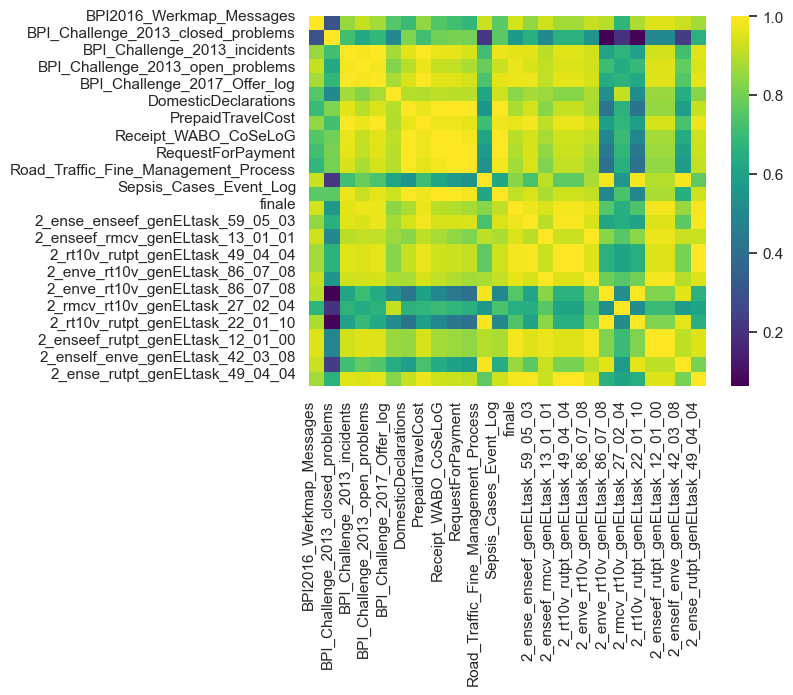

In [35]:
import matplotlib.ticker as ticker 
ft_similarity = cosine_similarity(nearest_to_bpics_ft.convert_dtypes().select_dtypes(exclude=['string']))
ft_similarity = pd.DataFrame(ft_similarity, columns=nearest_log_names, index=nearest_log_names)
print(ft_similarity.shape)
#print(ft_similarity)
#plt.imshow(ft_similarity, cmap='viridis', interpolation='nearest')
sns.heatmap(ft_similarity.astype(np.float16), cmap="viridis")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1.2))
ax.set_xticklabels(nearest_log_names, rotation=90)
ax.set_yticklabels(nearest_log_names)

plt.show()

(26, 8)
26
(26, 26)
(26, 26)


/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_17711/3534067398.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(nearest_log_names, rotation=90)
/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_17711/3534067398.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(nearest_log_names)


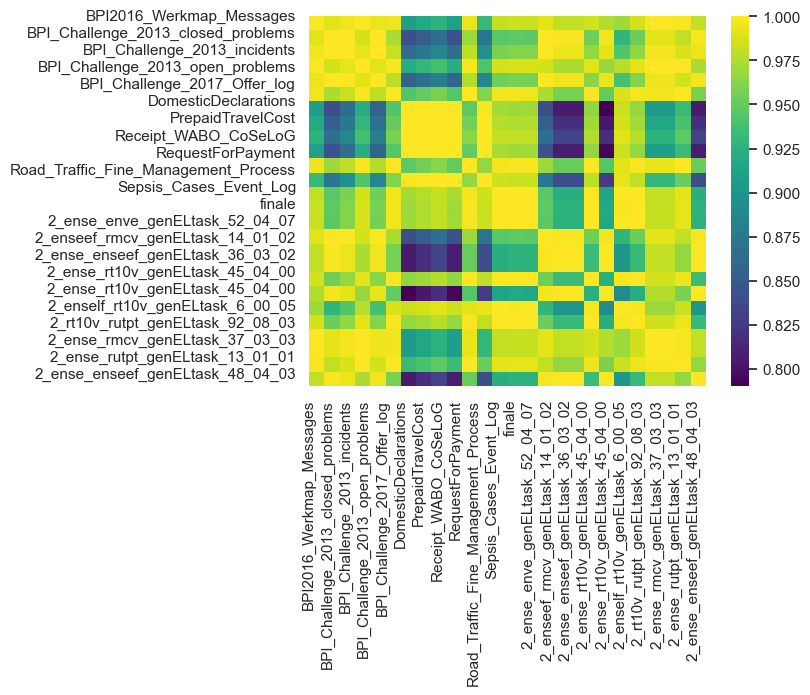

In [36]:


import matplotlib.ticker as ticker 
nearest_to_bpics_pdm = both_pd.loc[nearest_to_bpics]
print(nearest_to_bpics_pdm.shape)
nearest_log_names = nearest_to_bpics_pdm['log'].to_list()
print(len(nearest_log_names))
nearest_to_bpics_pdm

pdm_similarity = cosine_similarity(nearest_to_bpics_pdm.select_dtypes(exclude=['object'])) 
pdm_similarity = cosine_similarity(nearest_to_bpics_pdm[['precision_heuristics', 'precision_ilp']])
print(pdm_similarity.shape)
pdm_similarity = pd.DataFrame(pdm_similarity, columns=nearest_log_names, index=nearest_log_names)
print(pdm_similarity.shape)
#print(ft_similarity)
#plt.imshow(pdm_similarity, cmap='viridis', interpolation='nearest')
sns.heatmap(pdm_similarity.astype(np.float16), cmap="viridis")#, vmin=0.5, vmax=1)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1.2))
ax.set_xticklabels(nearest_log_names, rotation=90)
ax.set_yticklabels(nearest_log_names)

plt.show()

13
0
Index(['log', 'ratio_unique_traces_per_trace', 'ratio_most_common_variant',
       'ratio_top_10_variants', 'epa_normalized_variant_entropy',
       'epa_normalized_sequence_entropy',
       'epa_normalized_sequence_entropy_linear_forgetting',
       'epa_normalized_sequence_entropy_exponential_forgetting', 'source'],
      dtype='object')
(13, 9)
(13, 8)
['rutpt', 'rmcv', 'rt10v', 'enve', 'ense', 'enself', 'enseef']


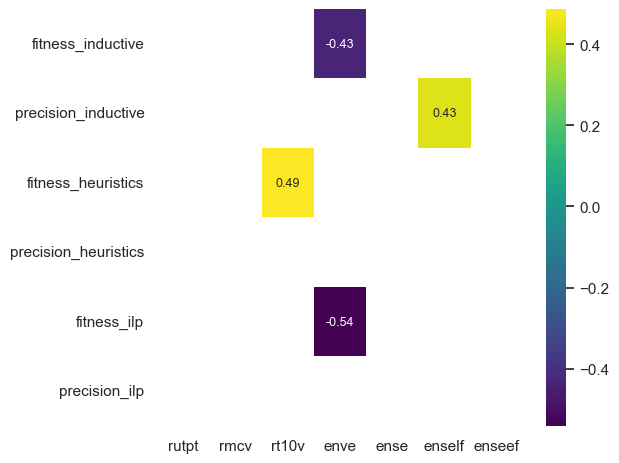

In [37]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.dirname("../tag/utils/io_helpers.py"))
from io_helpers import get_keys_abbreviation


#benchmarked_pdm = both_pd[both_pd['log'].isin(intersect_logs)].copy()
#print(len(benchmarked_pdm[benchmarked_pdm['source']=="BPICs"]['log']))



print(len(benchmarked_ft[benchmarked_ft['source']=="BPICs"]['log']))
benchmarked_ft_plot = nearest_to_bpics_ft.copy()[nearest_to_bpics_ft[both_df.columns]['source']=="Generated"]
benchmarked_pdm_plot = nearest_to_bpics_pdm.copy()[nearest_to_bpics_pdm[both_pd.columns]['source']=="Generated"] 
print(len(benchmarked_pdm_plot[benchmarked_pdm_plot['source']=="BPICs"]['log']))
print(benchmarked_ft.columns)
benchmarked_ft_plot

#benchmarked_ft = benchmarked_ft.head(10)
#benchmarked_pdm = benchmarked_pdm.head(10)

print(benchmarked_ft_plot.shape)
print(benchmarked_pdm_plot.shape)
tmp = list(benchmarked_ft_plot.columns[1:-1])
df_tmp = pd.DataFrame(index=benchmarked_pdm_plot.columns[1:-1], columns=tmp)
#print("Benchmark_pdm:", benchmarked_pdm.columns[1:-1])
#print ("Benchmark_ft:", tmp)


for feature in benchmarked_ft_plot.columns:
    if feature != 'log' and feature != 'source':
        for metric in benchmarked_pdm_plot.columns:
            if metric != 'log' and metric != 'source':
                #print(feature, benchmarked_pdm.columns[1])
                stat, p = kendalltau(benchmarked_ft_plot[feature], benchmarked_pdm_plot[metric])
                #print(feature, metric, p, p <= 0.05)
                df_tmp.loc[metric, feature] = stat*(1.0 if (p <= 0.05) else 0.0)

feature_keys = get_keys_abbreviation(df_tmp.columns).split("_")
print(feature_keys)
df_tmp.columns=feature_keys
# df_tmp[pd.isnan()]

sns.heatmap(df_tmp.fillna(0), annot=True, cmap="viridis", annot_kws={"size": 9})
ax = plt.gca()
sns.heatmap(df_tmp.fillna(0), mask=df_tmp.fillna(0)!=0, cmap="Greys", annot=False, cbar=False, ax=ax)
#ax.set_title("P-values of features leading to process discovery metrics", fontsize=15)
plt.tight_layout()
#plt.savefig("../output/plots/pearson_feature_PDmetric", dpi=300)

13
0
Index(['log', 'ratio_unique_traces_per_trace', 'ratio_most_common_variant',
       'ratio_top_10_variants', 'epa_normalized_variant_entropy',
       'epa_normalized_sequence_entropy',
       'epa_normalized_sequence_entropy_linear_forgetting',
       'epa_normalized_sequence_entropy_exponential_forgetting', 'source'],
      dtype='object')
(13, 9)


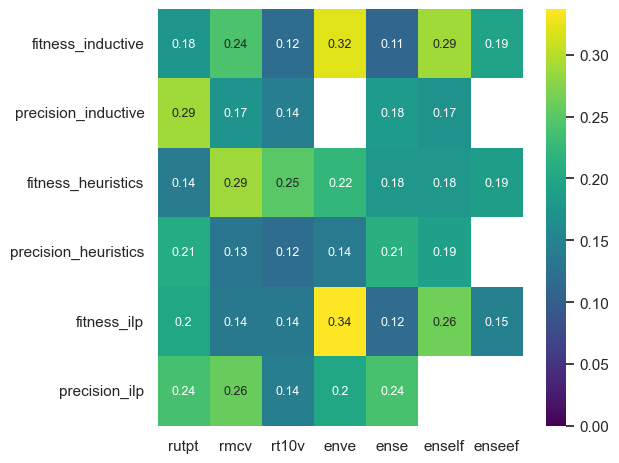

In [38]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

print(len(benchmarked_ft[benchmarked_ft['source']=="BPICs"]['log']))
benchmarked_ft_plot = nearest_to_bpics_ft.copy()[nearest_to_bpics_ft[both_df.columns]['source']=="Generated"]
benchmarked_pdm_plot = nearest_to_bpics_pdm.copy()[nearest_to_bpics_pdm[both_pd.columns]['source']=="Generated"] 
print(len(benchmarked_pdm_plot[benchmarked_pdm_plot['source']=="BPICs"]['log']))
print(benchmarked_ft.columns)

print(benchmarked_ft_plot.shape)
#print(benchmarked_pdm_plot.shape, benchmarked_pdm_plot['log'])
tmp = list(benchmarked_ft_plot.columns[1:-1])
df_tmp = pd.DataFrame(index=benchmarked_pdm_plot.columns[1:-1], columns=tmp)
#print("Benchmark_pdm:", benchmarked_pdm.columns[1:-1])
#print ("Benchmark_ft:", tmp)


for feature in benchmarked_ft_plot.columns:
    if feature != 'log' and feature != 'source':
        for metric in benchmarked_pdm.columns:
            if metric != 'log' and metric != 'source':
                #print(feature, benchmarked_pdm.columns[1])
                X = benchmarked_ft_plot[feature].to_numpy()
                ft_sim = (1-np.abs(np.subtract.outer(X,X)/max(X))).flatten()
                Y = benchmarked_pdm_plot[metric].to_numpy()
                pdm_sim = (1-np.abs(np.subtract.outer(Y,Y))/Y).flatten()
                #print(ft_sim.shape, pdm_sim.shape)
                stat, p = kendalltau(ft_sim, pdm_sim)
                #print(feature, metric, p, p <= 0.05)
                df_tmp.loc[metric, feature] = stat*(1.0 if (p <= 0.05) else 0)

# df_tmp[pd.isnan()]

feature_keys = get_keys_abbreviation(df_tmp.columns).split("_")
#print(feature_keys)
df_tmp.columns=feature_keys
sns.heatmap(df_tmp.fillna(0), annot=True, cmap="viridis", annot_kws={"size": 9})
ax = plt.gca()
sns.heatmap(df_tmp.fillna(0), mask=df_tmp.fillna(0)!=0, cmap="Greys", annot=True, annot_kws={"color":"white", "size": 9},  cbar=False, ax=ax)


#ax.set_title("P-values of feature similarity leading to process discovery metrics similarity", fontsize=15)
plt.tight_layout()
#plt.savefig("../output/plots/pearson_similarities_features_PDmetric", dpi=300)

In [39]:
rows_id = ['BPI2016_Complaints_processed', 'BPI2016_Werkmap_Messages_processed',
       'BPI_Challenge_2013_closed_problems', 'BPI_Challenge_2013_incidents',
       'BPI_Challenge_2013_open_problems', 'BPI_Challenge_2017_Offer_log',
       'DomesticDeclarations', 'PrepaidTravelCost', 'Receipt_WABO_CoSeLoG',
       'RequestForPayment']
#rows_id = nearest_log_names[:10]
print(rows_id)
cols_id = ['2_ense_enseef_genELtask_24_02_01',
       '2_enseef_rmcv_genELtask_14_01_02', '2_rmcv_rt10v_genELtask_15_01_03',
       '2_ense_rutpt_genELtask_73_06_06', '2_ense_rutpt_genELtask_63_05_07',
       '2_enseef_enve_genELtask_43_03_09', '2_ense_rutpt_genELtask_63_05_07',
       '2_ense_rutpt_genELtask_63_05_07', '2_enseef_enself_genELtask_59_05_03',
       '2_enseef_rmcv_genELtask_26_02_03']
#rows_id = nearest_log_names[10:]
#.loc[:,~features_df.columns.duplicated()].copy()
print(pdm_similarity.columns)
no_dupl = ((ft_similarity+pdm_similarity)*1/2)[list(set(cols_id))].loc[rows_id]#.copy()
print(no_dupl.shape)
print(no_dupl.columns)
no_dupl



['BPI2016_Complaints_processed', 'BPI2016_Werkmap_Messages_processed', 'BPI_Challenge_2013_closed_problems', 'BPI_Challenge_2013_incidents', 'BPI_Challenge_2013_open_problems', 'BPI_Challenge_2017_Offer_log', 'DomesticDeclarations', 'PrepaidTravelCost', 'Receipt_WABO_CoSeLoG', 'RequestForPayment']
Index(['BPI2016_Complaints', 'BPI2016_Werkmap_Messages',
       'BPI_Challenge_2013_closed_problems', 'BPI_Challenge_2013_incidents',
       'BPI_Challenge_2013_open_problems', 'BPI_Challenge_2017_Offer_log',
       'DomesticDeclarations', 'PrepaidTravelCost', 'Receipt_WABO_CoSeLoG',
       'RequestForPayment', 'Road_Traffic_Fine_Management_Process',
       'Sepsis_Cases_Event_Log', 'finale', '2_ense_enve_genELtask_52_04_07',
       '2_enseef_rmcv_genELtask_14_01_02', '2_ense_enseef_genELtask_36_03_02',
       '2_ense_rt10v_genELtask_45_04_00', '2_ense_rt10v_genELtask_45_04_00',
       '2_enself_rt10v_genELtask_6_00_05', '2_rt10v_rutpt_genELtask_92_08_03',
       '2_ense_rmcv_genELtask_37_03_

KeyError: "['2_ense_enseef_genELtask_24_02_01', '2_ense_rutpt_genELtask_63_05_07', '2_ense_rutpt_genELtask_73_06_06', '2_enseef_rmcv_genELtask_26_02_03', '2_enseef_enve_genELtask_43_03_09', '2_enseef_enself_genELtask_59_05_03'] not in index"

In [ ]:
plt.imshow(no_dupl, cmap='viridis', interpolation='nearest')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#x.set_xticklabels(rows_id, rotation=90)
#ax.set_yticklabels(col_id)
plt.colorbar()
plt.show()

In [ ]:
import sys
from sklearn.neighbors import NearestNeighbors
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

X = features_df.select_dtypes(exclude=['object'])
nbrs = NearestNeighbors(n_neighbors=344, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
#print(indices[:10])
#print(distances[:10])

furthest_to_bpics = [nearest[-1] for nearest in indices[:10]]
furthest_to_bpics = list(range(0,10)) + furthest_to_bpics
furthest_to_bpics_ft = features_df.loc[furthest_to_bpics]
#print(nearest_to_bpics_ft.shape)
furthest_log_names = furthest_to_bpics_ft['log'].to_list()
#print(len(nearest_log_names))
#furthest_to_bpics_ft

In [ ]:
import sys
from sklearn.neighbors import NearestNeighbors
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

X = features_df.select_dtypes(exclude=['object'])

In [ ]:
import matplotlib.ticker as ticker 
ft_similarity = cosine_similarity(furthest_to_bpics_ft.select_dtypes(exclude=['object']))
ft_similarity = pd.DataFrame(ft_similarity, columns=furthest_log_names, index=furthest_log_names)
print(ft_similarity.shape)
#print(ft_similarity)
#plt.imshow(ft_similarity, cmap='viridis', interpolation='nearest')
sns.heatmap(ft_similarity.astype(np.float16), cmap="viridis")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(nearest_log_names, rotation=90)
ax.set_yticklabels(nearest_log_names)

plt.show()